Image colorization project :
We train a CNN to take in greyscale images of ... and output their colorful and plausible colorization.

Imports required :

torch

skimage ? only used for rgb - lab parsing. Maybe we can do that ourselves to make some differentiation with the original project?

numpy

matplotlib

PIL ? only used to open images to rgb. We can use another library

In [153]:
import matplotlib.pyplot as plt 
import numpy as np
from PIL import Image
from skimage import color

import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

Load data, augment it, transform it to LAB compute stats on colors

In [154]:
#Data loading 

In [155]:
#LAB transform

[array([[[36.12643395, 74.7237478 ],
        [68.27200645, 57.15841288],
        [30.58742431,  7.87857414]],

       [[78.91004163,  6.35860304],
        [30.04847888, 22.25479969],
        [86.93046478, 58.48898759]],

       [[89.91140275, 79.43439784],
        [21.15828357, 92.47416693],
        [81.51745681, 44.85176954]]])]


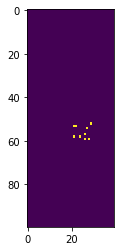

9
[(20, 90), (30, 10), (30, 20), (40, 70), (70, 60), (80, 10), (80, 40), (90, 60), (90, 80)]
[0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111, 0.1111111111111111]


In [156]:
#Color stats

# need dataset express like that: list of images (as tensor) with dim H x W x 2 ...
images = [np.random.rand(3,3,2) * 100]
print(images)

def getDiscretisedColor(a,b,gridSize):
    a = np.round(a/gridSize) * gridSize
    b = np.round(b/gridSize) * gridSize
    return (a,b)

def getMatrixIndex(a,b,gridSize):
    i = (a + 500) / gridSize
    j = (b + 200) / gridSize
    return (int(i),int(j))

def getColorValue(i,j,gridSize):
    a = i * gridSize - 500
    b = j * gridSize - 200
    return (a,b)

# Initiate the proba distribution of ab pairs in the images dataset (discretised).
gridSize = 10
colorProbabilities = np.zeros((1000 // gridSize, 400 // gridSize))

# Compute the proba distribution of the ab pairs in the images dataset (discretised).
nbOfAnalysedPixels = 0
for image in images:
    for h in range (image.shape[0]):
        for w in range (image.shape[1]):
            (a,b) = getDiscretisedColor(image[h][w][0],image[h][w][1],gridSize)
            (i,j) = getMatrixIndex(a,b,gridSize)
            colorProbabilities[i][j] += 1
            nbOfAnalysedPixels += 1
colorProbabilities = colorProbabilities / nbOfAnalysedPixels

# + display distribution in 2d plot ? like in paper (here, very simple)
plt.imshow(colorProbabilities, interpolation='none')
plt.show()

# Get the vector of proba of ab pairs that are "in gamut"
inGamutColors = []
inGamutColorsProbas = []
for i in range (colorProbabilities.shape[0]):
    for j in range (colorProbabilities.shape[1]):
        currentColorPorba = colorProbabilities[i][j]
        if currentColorPorba != 0:
            (a,b) = getColorValue(i,j,gridSize)
            inGamutColors.append((a,b))
            inGamutColorsProbas.append(currentColorPorba)
        
Q = len(inGamutColors) 
p = torch.tensor(inGamutColorsProbas)
print(Q)
print(inGamutColors)
print(inGamutColorsProbas)
Q = 1 # to remove


In [157]:
#Define pixel weight vector (class rebalancing)

# Set the parameters (from paper, need empirical value).
lambda_uniform = 1/2 
sigma = 5 # gaussian kernel parameter

# Compute a smooth version of the empirical pixel color distribution.
p_smooth = p # how to do that ? gaussian kernel ? to do

# Compute the weight vector.
pixelsWeights = torch.reciprocal((1 - lambda_uniform) * p_smooth + lambda_uniform / Q)

# Normalise the weight vector according to p_smooth (E[W] = 1).
E_W = torch.sum(p_smooth * pixelsWeights)
scale_factor = 1 / E_W
pixelsWeights = scale_factor * pixelsWeights 

Define and instantiate Convolutional NN

In [158]:
#NN def

Define optimizer

In [159]:
#ADAM

Define Loss

In [160]:
#Convert a true pixel Y to a distribution Z (soft encoding)

# to implement...
def getColorDistribution(Y):
    return 

In [161]:
#Convert a distribution Z to a true pixel Y (point estimate)

# to implement...
def getColorEstimate(Z):
    return 

In [162]:
#v(Z_hw) weight in paper (section 2)

def getPixelsWeights(Z):
    W = torch.argmax(Z, dim=2)
    for i in range(W.size(dim=0)):
        for j in range(W.size(dim=1)):
            W[i,j] = pixelsWeights(W[i,j])

    return W


In [163]:
#loss function 

def multinomialCrossEntropyLoss(Z_estimate, Z):
    W = getPixelsWeights(Z)
    L = - sum(W * torch.sum(Z * torch.log10(Z_estimate), dim=2))

    return L
    


Main training loop and additional function TBD